In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

plt.ion()   # interactive mode


In [20]:
full_mean = 132.35524/255
full_std = 44.076332/255

In [21]:
class FacesDataset(Dataset):
    """Faces dataset."""

    def __init__(self, X, y, transform=None):
        self.image_vectors = X
        self.targets = y
        self.transform = transform

    def __len__(self):
        return len(self.image_vectors)

    def __getitem__(self, idx):

        one_dim_avg = self.image_vectors[idx]
        one_dim_image = np.reshape(one_dim_avg, (50, 37)).astype('uint8')
        im = Image.fromarray(one_dim_image)
        imrgb = Image.merge('RGB', (im, im, im))

        if self.transform:
            imrgb = self.transform(imrgb)

        return (imrgb, self.targets[idx])


In [22]:
# too: add more transforms later
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[full_mean, full_mean, full_mean],
                             std=[full_std, full_std, full_std])
    ]),
}

In [23]:

# %% loading the raw data
X_train_raw = np.load('X_train.npy')
y_train_raw = np.load('y_train.npy')

X_train, X_val, y_train, y_val = train_test_split(X_train_raw,
                                                  y_train_raw,
                                                  random_state=1)

faces_datasets = {
    'train': FacesDataset(X_train, y_train,
                          transform=data_transforms['train']),
    'val': FacesDataset(X_val, y_val, transform=data_transforms['val'])
}

dataloaders = {x: DataLoader(faces_datasets[x], batch_size=4,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(faces_datasets[x]) for x in ['train', 'val']}
use_gpu = torch.cuda.is_available()


In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()
    time_elasped = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elasped // 60, time_elasped % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([full_mean, full_mean, full_mean])
    std = np.array([full_std, full_std, full_std])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [26]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


Epoch 0/24
----------
train Loss: 0.2847 Acc: 0.6133
val Loss: 0.1338 Acc: 0.8017

Epoch 1/24
----------
train Loss: 0.0935 Acc: 0.8867
val Loss: 0.0336 Acc: 0.9504

Epoch 2/24
----------
train Loss: 0.0343 Acc: 0.9655
val Loss: 0.0174 Acc: 0.9835

Epoch 3/24
----------
train Loss: 0.0124 Acc: 0.9917
val Loss: 0.0123 Acc: 0.9876

Epoch 4/24
----------
train Loss: 0.0072 Acc: 0.9972
val Loss: 0.0118 Acc: 0.9793

Epoch 5/24
----------
train Loss: 0.0075 Acc: 0.9917
val Loss: 0.0224 Acc: 0.9669

Epoch 6/24
----------
train Loss: 0.0073 Acc: 0.9903
val Loss: 0.0165 Acc: 0.9669

Epoch 7/24
----------
train Loss: 0.0042 Acc: 0.9959
val Loss: 0.0116 Acc: 0.9835

Epoch 8/24
----------
train Loss: 0.0047 Acc: 0.9972
val Loss: 0.0117 Acc: 0.9835

Epoch 9/24
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.0131 Acc: 0.9793

Epoch 10/24
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.0127 Acc: 0.9793

Epoch 11/24
----------
train Loss: 0.0029 Acc: 0.9972
val Loss: 0.0123 Acc: 0.9835

Ep

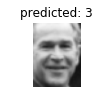

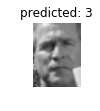

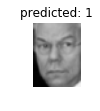

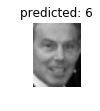

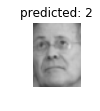

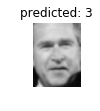

In [27]:
model_ft = models.resnet18(pretrained=True)
# swap out the last layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

criterion = nn.CrossEntropyLoss()

# todo: Try adam
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# %%


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)
plt.ioff()
plt.show()

In [30]:
# save model parameters only
torch.save(model_ft.state_dict(), 'resnet18_24epochs.pt')
# save entire model
torch.save(model_ft, 'resnet18_24epochs.model')